# AI for Predicting Age Specific Human Skeleton

## Model Testing

### Importing Libraries

In [1]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as tf

2025-07-01 02:12:22.653778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751335942.857009      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751335942.917763      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Preparation

In [2]:
# 📁 Paths
train_csv_path = '/kaggle/input/rsna-bone-age/boneage-training-dataset.csv'
test_csv_path = '/kaggle/input/rsna-bone-age/boneage-test-dataset.csv'
train_img_dir = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
test_img_dir = '/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset'

In [3]:
# 📄 Load CSV
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [4]:
# 🖼 Add image paths
train_df['path'] = train_df['id'].astype(str) + '.png'
test_df['path'] = test_df['Case ID'].astype(str) + '.png'

In [5]:
# 📊 Normalize target
mean_boneage = train_df['boneage'].mean()
std_boneage = train_df['boneage'].std()
train_df['boneage_z'] = (train_df['boneage'] - mean_boneage) / std_boneage

In [6]:
# 🔀 Train-validation split
train_data, val_data = train_test_split(train_df, test_size=0.15, random_state=42)

### Data Augmentation

In [7]:
# 📈 Data Generator
class BoneAgeGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, img_size=224, batch_size=32, training=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.training = training
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, genders, labels = [], [], []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, row['path'])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=-1)
            img = np.repeat(img, 3, axis=-1)  # Convert to 3-channel RGB

            if self.augment:
                img = self.datagen.random_transform(img)

            images.append(img)
            genders.append(row['male'])
            if self.training:
                labels.append(row['boneage_z'])

        images = np.array(images)
        genders = np.array(genders).reshape(-1, 1)

        if self.training:
            return (images, genders), np.array(labels)
        else:
            return(images, genders)

### 📦 Data Generators

In [8]:
train_gen = BoneAgeGenerator(train_data, train_img_dir, augment=True)
val_gen = BoneAgeGenerator(val_data, train_img_dir, augment=False)

🔹 Evaluating model: EfficientNetB0
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
🔹 Evaluating model: EfficientNetB5
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
🔹 Evaluating model: ResNet101
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
🔹 Evaluating model: Xception
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


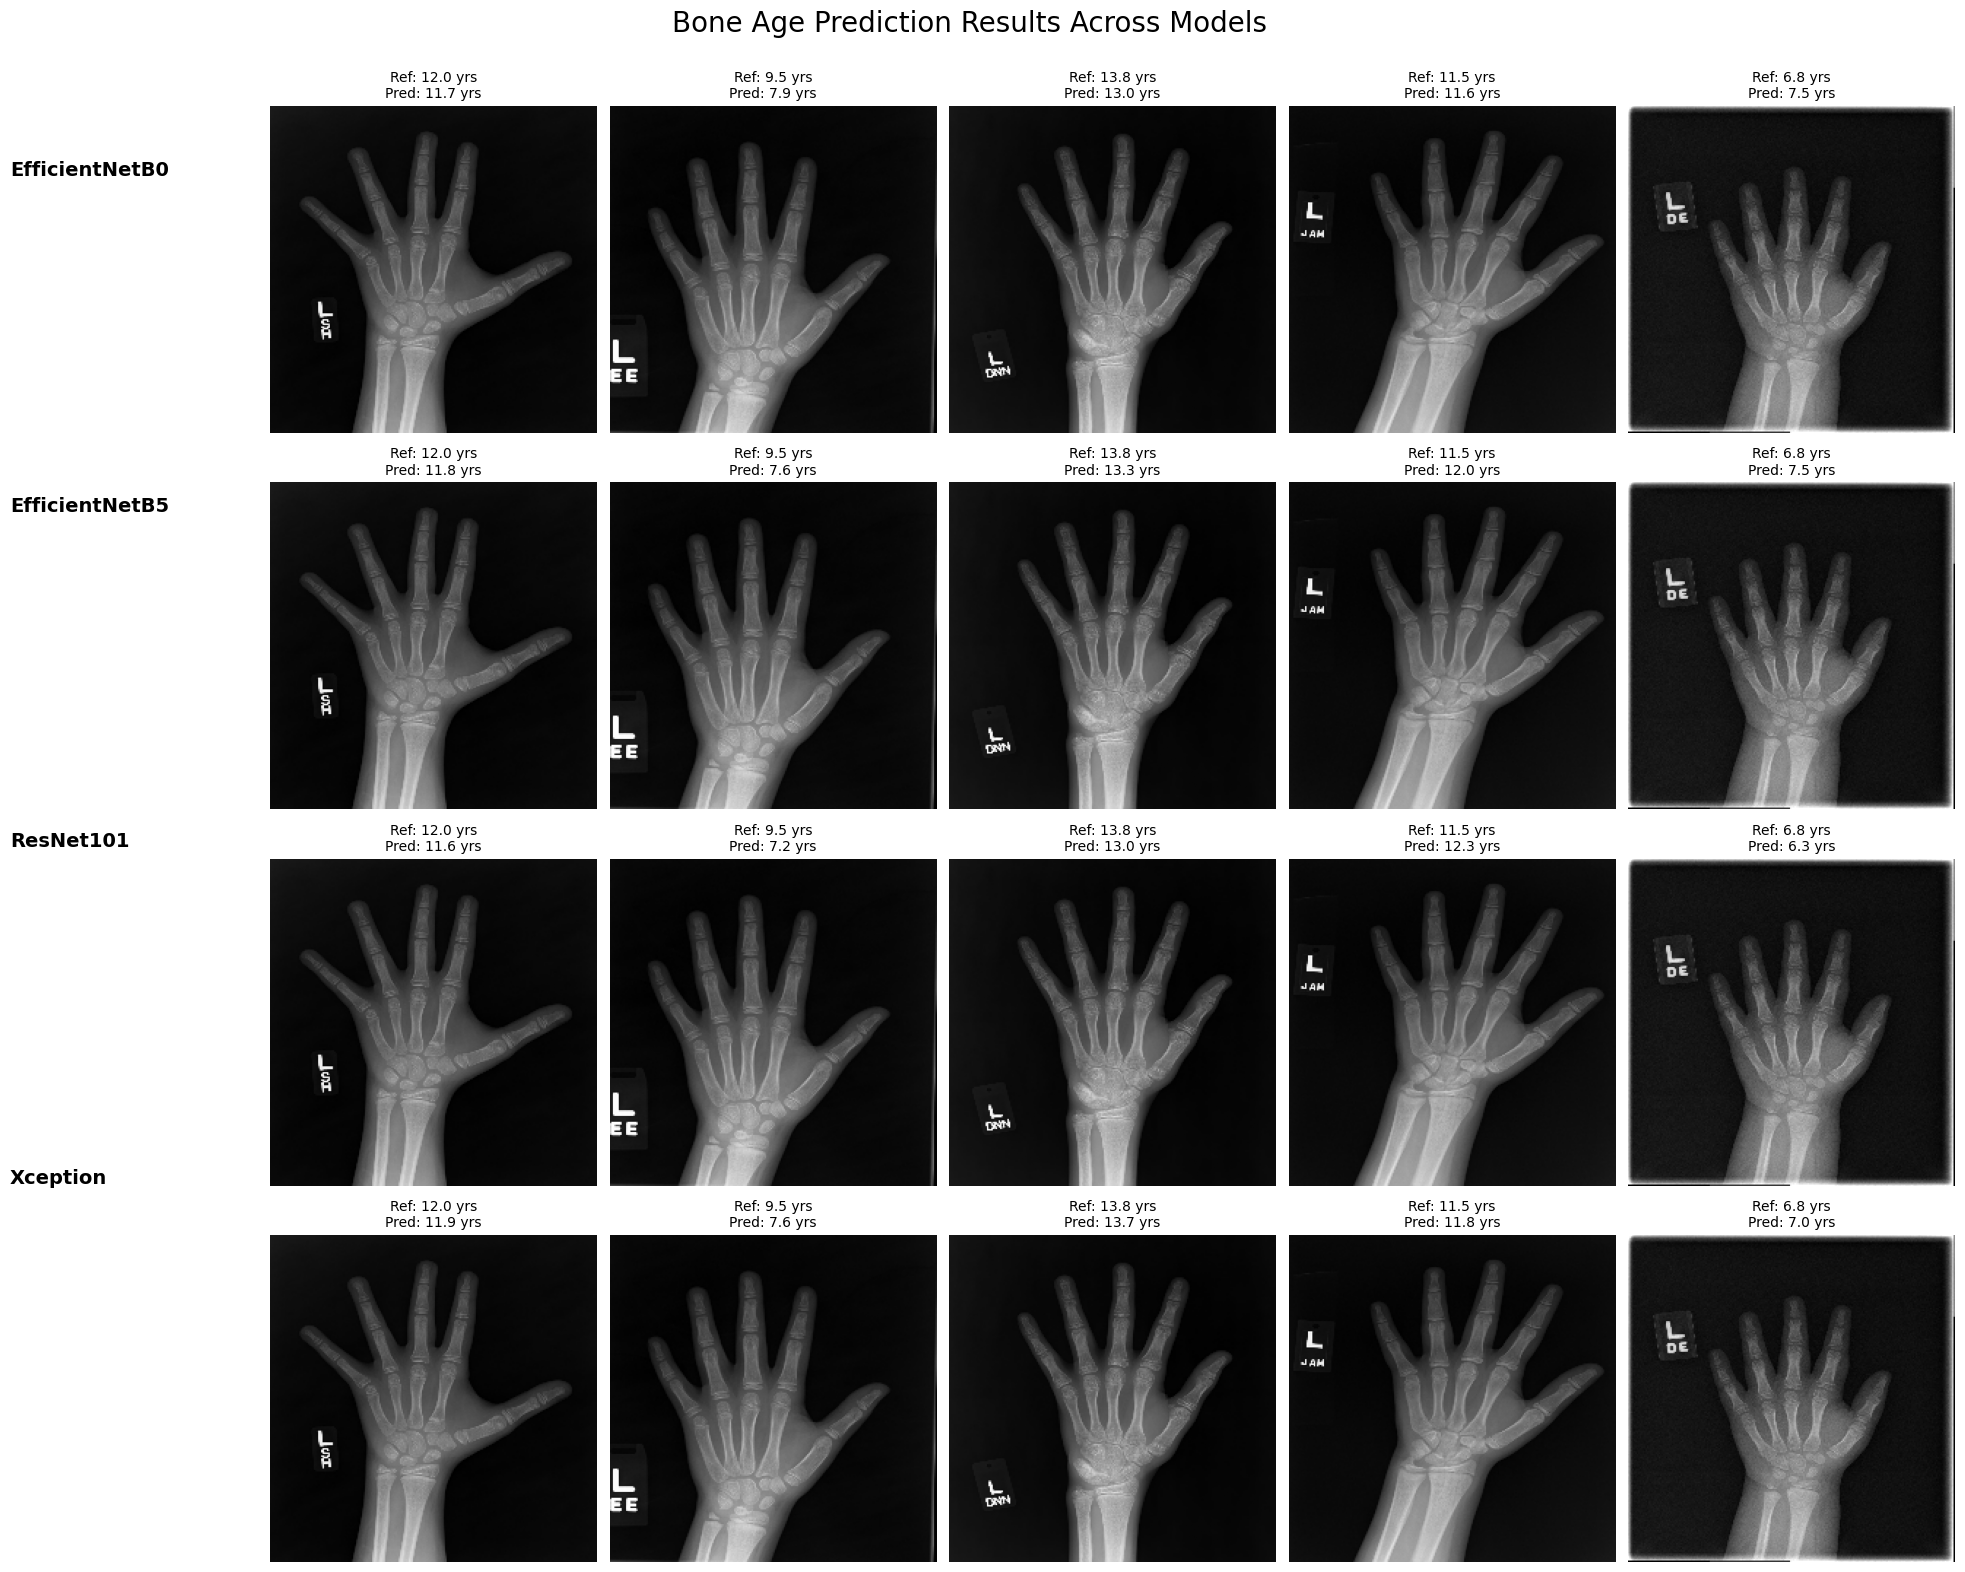

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# Paths to your saved models
model_paths = {
    "EfficientNetB0": "/kaggle/input/outputs/keras/default/1/EffecientNetB0/EffecientnetB0.keras",
    "EfficientNetB5": "/kaggle/input/outputs/keras/default/1/EfficientNetB5/EfficientnetB5.keras",
    "ResNet101": "/kaggle/input/outputs/keras/default/1/ResNet101/Resnet101.keras",
    "Xception": "/kaggle/input/outputs/keras/default/1/Xception/Xception.keras"
}

# Select 5 consistent samples
sample_df = val_data.sample(5, random_state=42).reset_index(drop=True)

# Create figure
fig, axes = plt.subplots(
    nrows=len(model_paths),
    ncols=5,
    figsize=(20, 16)
)

# Ensure axes is a 2D array
if len(model_paths) == 1:
    axes = np.expand_dims(axes, axis=0)

# Loop over models
for row_idx, (model_name, model_path) in enumerate(model_paths.items()):
    print(f"🔹 Evaluating model: {model_name}")

    model = tf.keras.models.load_model(model_path)

    # Loop over the 5 images
    for col_idx, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(train_img_dir, row["path"])

        # Preprocess image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = img.astype("float32") / 255.0
        img = np.expand_dims(img, axis=-1)
        img = np.repeat(img, 3, axis=-1)
        img_batch = np.expand_dims(img, axis=0)
        gender = np.array([[row["male"]]])

        # Predict
        pred_z = model.predict([img_batch, gender]).flatten()[0]
        pred_months = pred_z * std_boneage + mean_boneage
        pred_years = pred_months / 12
        true_years = row["boneage"] / 12

        # Plot
        ax = axes[row_idx, col_idx]
        ax.imshow(img.squeeze(), cmap="gray")
        ax.axis("off")
        ax.set_title(
            f"Ref: {true_years:.1f} yrs\nPred: {pred_years:.1f} yrs",
            fontsize=10
        )

# 🏷️ Add model labels beside each row using fig.text
for row_idx, model_name in enumerate(model_paths.keys()):
    # Calculate vertical position in figure coordinates
    ypos = 0.88 - row_idx * (0.21)
    fig.text(
        0.02, ypos,
        model_name,
        fontsize=14,
        va='center',
        ha='left',
        weight='bold'
    )

plt.suptitle("Bone Age Prediction Results Across Models", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92, left=0.15)
plt.show()

🔹 Evaluating model: EfficientNetB0
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
🔹 Evaluating model: EfficientNetB5
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
🔹 Evaluating model: ResNet101
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
🔹 Evaluating model: Xception
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


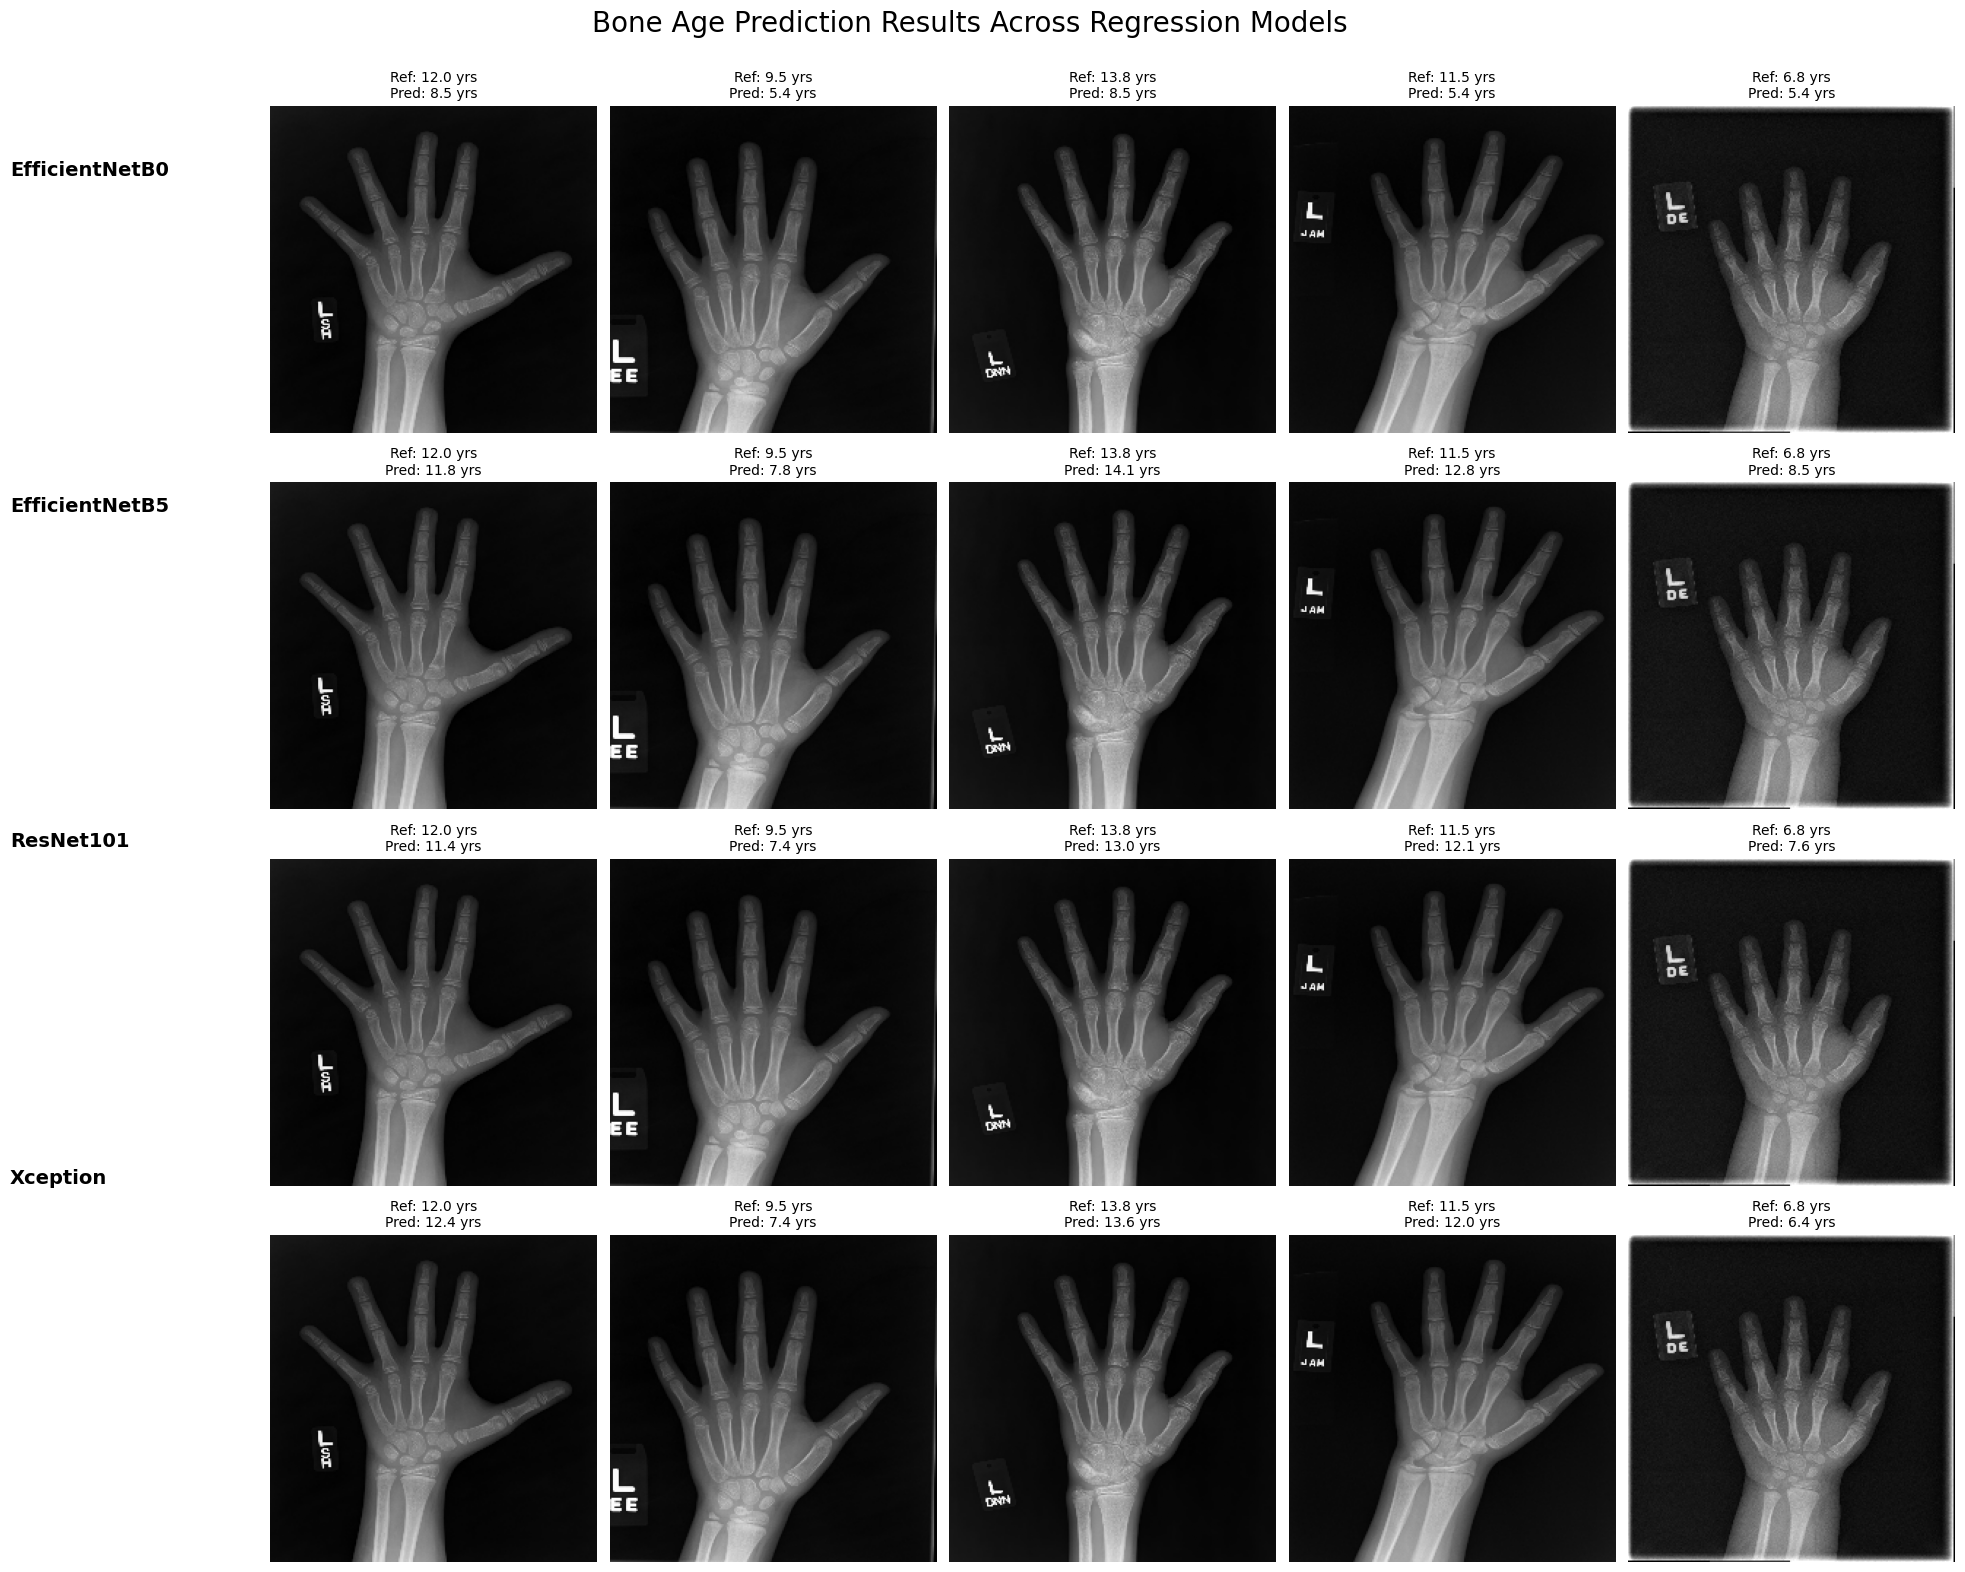

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# Paths to your saved models
model_paths = {
    "EfficientNetB0": "/kaggle/input/outputs/keras/default/1/EffecientNetB0/EffecientnetB0_Reg.keras",
    "EfficientNetB5": "/kaggle/input/outputs/keras/default/1/EfficientNetB5/EfficientnetB5_reg.keras",
    "ResNet101": "/kaggle/input/outputs/keras/default/1/ResNet101/Resnet101_reg.keras",
    "Xception": "/kaggle/input/outputs/keras/default/1/Xception/Xception_reg.keras"
}

# Select 5 consistent samples
sample_df = val_data.sample(5, random_state=42).reset_index(drop=True)

# Create figure
fig, axes = plt.subplots(
    nrows=len(model_paths),
    ncols=5,
    figsize=(20, 16)
)

# Ensure axes is a 2D array
if len(model_paths) == 1:
    axes = np.expand_dims(axes, axis=0)

# Loop over models
for row_idx, (model_name, model_path) in enumerate(model_paths.items()):
    print(f"🔹 Evaluating model: {model_name}")

    model = tf.keras.models.load_model(model_path)

    # Loop over the 5 images
    for col_idx, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(train_img_dir, row["path"])

        # Preprocess image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = img.astype("float32") / 255.0
        img = np.expand_dims(img, axis=-1)
        img = np.repeat(img, 3, axis=-1)
        img_batch = np.expand_dims(img, axis=0)
        gender = np.array([[row["male"]]])

        # Predict
        pred_z = model.predict([img_batch, gender]).flatten()[0]
        pred_months = pred_z * std_boneage + mean_boneage
        pred_years = pred_months / 12
        true_years = row["boneage"] / 12

        # Plot
        ax = axes[row_idx, col_idx]
        ax.imshow(img.squeeze(), cmap="gray")
        ax.axis("off")
        ax.set_title(
            f"Ref: {true_years:.1f} yrs\nPred: {pred_years:.1f} yrs",
            fontsize=10
        )

# 🏷️ Add model labels beside each row using fig.text
for row_idx, model_name in enumerate(model_paths.keys()):
    # Calculate vertical position in figure coordinates
    ypos = 0.88 - row_idx * (0.21)
    fig.text(
        0.02, ypos,
        model_name,
        fontsize=14,
        va='center',
        ha='left',
        weight='bold'
    )

plt.suptitle("Bone Age Prediction Results Across Regression Models", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92, left=0.15)
plt.show()